In [0]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

**데이터 불러오기**

In [0]:
(X_train_all, y_train_all), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

In [0]:
X_train_all.shape, y_train_all.shape

((60000, 28, 28), (60000,))

In [0]:
np.bincount(y_train_all)

array([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000])

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X_train_all, y_train_all, stratify=y_train_all, test_size=0.2, random_state=42
)

In [0]:
np.bincount(y_train)

array([4800, 4800, 4800, 4800, 4800, 4800, 4800, 4800, 4800, 4800])

In [0]:
np.bincount(y_val)

array([1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200])

**원-핫 인코딩**

In [0]:
# 표준화
X_train = X_train / 255
X_val = X_val / 255

In [0]:
# 2차원을 1차원 배열로 변환
X_train = X_train.reshape(-1, 784)
X_val = X_val.reshape(-1, 784)

In [0]:
X_train.shape, X_val.shape

((48000, 784), (12000, 784))

In [0]:
# 원-핫 인코딩
y_train_encoded = tf.keras.utils.to_categorical(y_train)
y_val_encoded = tf.keras.utils.to_categorical(y_val)

In [0]:
y_train_encoded.shape, y_val_encoded.shape

((48000, 10), (12000, 10))

In [0]:
y_train[0], y_train_encoded[0]

(6, array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.], dtype=float32))

**다중 분류 클래스 생성**

In [0]:
class MultiClassNetwork:
  def __init__(self, units=10, batch_size=32, learning_rate=0.1, l1=0, l2=0):
    self.units = units
    self.batch_size = batch_size
    self.w1 = None
    self.b1 = None
    self.w2 = None
    self.b2 = None
    self.a1 = None
    self.losses = []
    self.val_losses = []
    self.lr = learning_rate
    self.l1 = l1
    self.l2 = l2

  def forpass(self, x):
    z1 = np.dot(x, self.w1) + self.b1
    self.a1 = self.sigmoid(z1)
    z2 = np.dot(self.a1, self.w2) + self.b2
    return z2

  def backprop(self, x, err):
    m = len(x)
    w2_grad = np.dot(self.a1.T, err) / m
    b2_grad = np.sum(err) / m
    err_to_hidden = np.dot(err, self.w2.T) * self.a1 * (1-self.a1)
    w1_grad = np.dot(x.T, err_to_hidden) / m
    b1_grad = np.sum(err_to_hidden, axis=0) / m
    return w1_grad, b1_grad, w2_grad, b2_grad

  def sigmoid(self, z):
    a = 1 / (1 + np.exp(-z))
    return a

  def softmax(self, z):
    exp_z = np.exp(z)
    return exp_z / np.sum(exp_z, axis=1).reshape(-1, 1)

  def init_weight(self, n_features, n_classes):
    self.w1 = np.random.normal(0, 1, (n_features, self.units))
    self.b1 = np.zeros(self.units)
    self.w2 = np.random.normal(0, 1, (self.units, n_classes))
    self.b2 = np.zeros(n_classes)

  def fit(self, x, y, epochs=None, x_val=None, y_val=None):
    np.random.seed(42)
    m = len(x)
    self.init_weight(x.shape[1], y.shape[1])

    for i in range(epochs):
      loss = 0

      for x_batch, y_batch in self.gen_batch(x, y):
        a = self.training(x_batch, y_batch, m)
        a = np.clip(a, 1e-10, 1 - 1e-10)
        loss += np.sum(-y_batch * np.log(a))  # 크로스 엔트로피

      self.losses.append((loss + self.reg_loss()) / m)
      self.update_val_loss(x_val, y_val)

  def gen_batch(self, x, y):
    length = len(x)
    bins = length // self.batch_size

    if length % self.batch_size:
      bins += 1

    indexes = np.random.permutation(np.arange(length))
    x = x[indexes]
    y = y[indexes]

    for i in range(bins):
      start = self.batch_size * i
      end = self.batch_size * (i + 1)
      yield x[start:end], y[start:end]

  def training(self, x, y, m):
    z = self.forpass(x)
    a = self.softmax(z)
    err = -(y - a)
    w1_grad, b1_grad, w2_grad, b2_grad = self.backprop(x, err)
    w1_grad += (self.l1 * np.sign(self.w1) + self.l2 * self.w1) / m
    w2_grad += (self.l1 * np.sign(self.w2) + self.l2 * self.w2) / m
    self.w1 -= self.lr * w1_grad
    self.b1 -= self.lr * b1_grad
    self.w2 -= self.lr * w2_grad
    self.b2 -= self.lr * b2_grad
    return a

  def reg_loss(self):
    reg_1 = self.l1 * (np.sum(np.abs(self.w1)) + np.sum(np.abs(self.w2)))
    reg_2 = self.l2 / 2 * (np.sum(self.w1 ** 2) + np.sum(self.w2 ** 2))
    return reg_1, reg_2

  def update_val_loss(self, x_val, y_val):
    val_loss = 0
    z = self.forpass(x_val)
    a = self.softmax(z)
    a = np.clip(a, 1e-10, 1 - 1e-10)
    val_loss = np.sum(-y_val * np.log(a))  # 크로스 엔트로피
    self.val_losses.append((val_loss + self.reg_loss()) / len(y_val))

  def predict(self, x):
    z = self.forpass(x)
    return np.argmax(z, axis=1)

  def score(self, x, y):
    return np.mean(self.predict(x) == np.argmax(y, axis=1))

**모델 생성 & 훈련**

In [0]:
fc = MultiClassNetwork(units=100, batch_size=256)
fc.fit(X_train, y_train_encoded, x_val=X_val, y_val=y_val_encoded, epochs=40)

In [0]:
print('모델 검증 점수: {:.2f}'.format(fc.score(X_val, y_val_encoded)))

모델 검증 점수: 0.82


**손실 그래프 그리기**

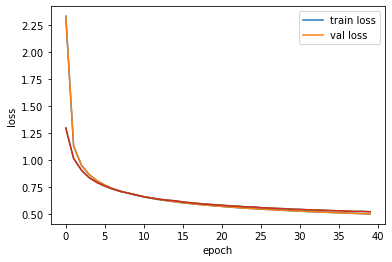

In [0]:
plt.plot(fc.losses)
plt.plot(fc.val_losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'val loss'])
plt.show()

**텐서플로우와 케라스를 사용한 다중분류**

In [0]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

In [0]:
# 신경망 모델 생성
model = Sequential()

# 완전 연결층 추가
model.add(Dense(100, activation='sigmoid', input_shape=(784,)))  # 은닉층
model.add(Dense(10, activation='softmax'))  # 출력층

# 옵티마이저(최적화 알고리즘)와 손실 함수 지정
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])  # 측정에 정확도 추가

In [0]:
# 훈련 데이터를 사용하여 에포크 횟수만큼 모델 훈련
hist = model.fit(X_train, y_train_encoded, epochs=40, validation_data=(X_val, y_val_encoded))

In [0]:
print(hist.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


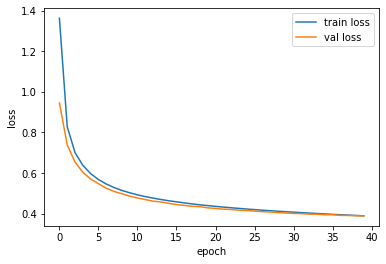

In [0]:
# 손실 그래프
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'val loss'])
plt.show()

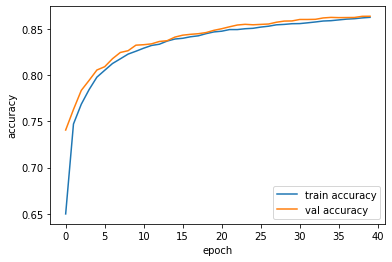

In [0]:
# 정확도 그래프
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train accuracy', 'val accuracy'])
plt.show()

### 용어 정리

**1) 소프트맥스 함수**
- 각 확률의 출력값의 합을 1로 만듬

- $ \frac{e^{z_i}}{e^{z_1}+e^{z_1}+e^{z_1}} $

**2) 크로스 엔트로피 손실함수와 로지스틱 손실함수(이진 크로스 엔트로피) 비교**
- 로지스틱 손실함수는 양성 클래스와 음성 클래스로 이진 분류할 때 사용하는 손실 함수이므로 두개의 항만 가지는 반면에 크로스 엔트로피 손실 함수는 2개 이상의 클래스를 분류할 때 사용하는 손실 함수이므로 모든 클래스에 대한 손실을 구한 후 합을 구하지만 결론적으로는 예측값이 1인 항만 남는다.